In [1]:
from __future__ import print_function
import numpy as np
from astropy.table import Table, Column, MaskedColumn, join, vstack
from astropy.io import ascii, fits

from os import path
import os
import sys
from datetime import date

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

###Plot formatting commands
plt.rc('figure', figsize=(10.0, 7.1)) #bigger figures
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title
plt.rc('text', usetex=True)
font = {'family':'serif','size':16, 'serif': ['computer modern roman']}
plt.rc('font',**font)
###End formatting commands


<h3>A quick MC integrator introduction</h3>

In [2]:
# from https://pypi.org/project/mcint/ -- no longer pip installed, but read from a hard copy
import mcint
import random
import math
# this is the package I was using before, but this also looks promising, I wonder if this is faster
# for truly huge integrals:
# https://vegas.readthedocs.io/en/latest/tutorial.html
# one-dimensional example

def integrand(x): # Describe the function being integrated
    return (x**2)

def sampler(): # Describe how Monte Carlo samples are taken
    while True:
        yield random.random()

result, error = mcint.integrate(integrand, sampler(), measure=1.0, n=10000)

print("The integral of x**2 between 0 and 1 is approximately", result, error)
print("analytical result=",1./3.)


The integral of x**2 between 0 and 1 is approximately 0.3369212555378203 0.004509496778834673
analytical result= 0.3333333333333333


<h1>Make some choices here</h1>
<br>Choice number one is the quality of the simulation. Make sure that nmc_large=10000 for quick calculations and 100000 or above for the calculations that go into the paper. The high quality ones take maybe 10-15 min or so. 
<br>Then there is the choice between dust vs electrons. Uncomment one or the other. 

In [3]:
# CHOICE NUMBER 1
nmc_large=100000
begin_fname2='low_'
if (nmc_large>=100000): begin_fname2='high_'

# CHOICE NUMBER 2
electrons=True
if (electrons):
    # for electrons: phase function of scattering and phase function of polarization
    def phase_int(psi_deg): return 1.+math.cos(psi_deg*math.pi/180.)**2
    def pol_int(psi_deg): return math.sin(psi_deg*math.pi/180.)**2/(1.+math.cos(psi_deg*math.pi/180.)**2)
    begin_fname1='el_'
else: 
    # for dust: phase function of scattering and phase function of polarization
    # read data from data files and interpolate
    phase_all=ascii.read('draine_scat_smc_opt.dat',data_start=18)
    phase_ang=phase_all['col1']
    phase_num=phase_all['col8']*1.e23
    phase_int=interpolate.interp1d(phase_ang,phase_num,'cubic')
    pol_all=ascii.read('draine_pol_smc_opt.dat',data_start=11)
    pol_ang=pol_all['col1']
    pol_num=pol_all['col8']
    pol_int=interpolate.interp1d(pol_ang,pol_num,'cubic')
    begin_fname1='dust_'

# initialize output files based on these choices: 
begin_fname=begin_fname1+begin_fname2

In [4]:
# these options don't need to be messed with:
plt.interactive(True)
sig=0.01 # Gaussian width for approximating delta function
nmc_small=10000 # this is for the unobscured profile and the continuum

<h3>Polar outflow edge-on</h3>

In [5]:
# the geometry of the emitter, scatterer and observer and resulting file names
theta1=0.*math.pi/180. # movement of the emitter
theta2=60.*math.pi/180.
theta_s1=0.*math.pi/180. # movement of the scatterer
theta_s2=60.*math.pi/180.
theta_obs=90.*math.pi/180. # observer's angle
vin=1.0 # emitting outflow velocity
vscat=1.0 # scattering outflow velocity
fname=begin_fname+'00_60_00_60_90'

datfile=fname+'.tbl'
outfile=fname+'.pdf'

In [6]:
def ndelta(arg):
    # it needs to be properly normalized
    return(math.exp(-arg**2/(2*sig**2))/(math.sqrt(2*math.pi)*sig))

def integrand_i(x):
    # integrand including the phase function
    theta = x[0]
    phi = x[1]
    theta_s=x[2]
    phi_s=x[3]
    vlos=x[4]
    # this is the scattering angle, angle between n_prop and n_obs
    psi=math.acos(math.sin(theta_s)*math.sin(phi_s)*math.sin(theta_obs)+math.cos(theta_s)*math.cos(theta_obs))
    # this is the argument of the delta function
    arg=vlos+vin*(math.cos(theta)*math.cos(theta_s)+math.sin(theta)*math.sin(theta_s)*math.cos(phi-phi_s))-\
        vscat*(1.-math.cos(psi))
    return(math.sin(theta)*math.sin(theta_s)*ndelta(arg)*phase_int(psi*180./math.pi))
    # I think this integrand is all fixed, including psi and difference in emitting and scattering velocities

def integrand_q(x):
    # integrand for the Q polarization
    theta = x[0]
    phi = x[1]
    theta_s=x[2]
    phi_s=x[3]
    vlos=x[4]
    # this is the scattering angle, angle between n_prop and n_obs
    psi=math.acos(math.sin(theta_s)*math.sin(phi_s)*math.sin(theta_obs)+math.cos(theta_s)*math.cos(theta_obs))
    # this is the argument of the delta function
    arg=vlos+vin*(math.cos(theta)*math.cos(theta_s)+math.sin(theta)*math.sin(theta_s)*math.cos(phi-phi_s))-\
        vscat*(1.-math.cos(psi))
    # this is the geometric dilution factor
    nxprime=math.sin(theta_obs)*math.cos(theta_s)-math.cos(theta_obs)*math.sin(theta_s)*math.sin(phi_s)
    nyprime=math.sin(theta_s)*math.cos(phi_s)
    qfactor=-pol_int(psi*180./math.pi)*(nxprime**2-nyprime**2)/(nxprime**2+nyprime**2)
    return(math.sin(theta)*math.sin(theta_s)*ndelta(arg)*phase_int(psi*180./math.pi)*qfactor)

def integrand_u(x):
    # integrand for the U polarization
    theta = x[0]
    phi = x[1]
    theta_s=x[2]
    phi_s=x[3]
    vlos=x[4]
    # this is the scattering angle, angle between n_prop and n_obs
    psi=math.acos(math.sin(theta_s)*math.sin(phi_s)*math.sin(theta_obs)+math.cos(theta_s)*math.cos(theta_obs))
    # this is the argument of the delta function
    arg=vlos+vin*(math.cos(theta)*math.cos(theta_s)+math.sin(theta)*math.sin(theta_s)*math.cos(phi-phi_s))-\
        vscat*(1.-math.cos(psi))
    # this is the geometric dilution factor
    nxprime=math.sin(theta_obs)*math.cos(theta_s)-math.cos(theta_obs)*math.sin(theta_s)*math.sin(phi_s)
    nyprime=math.sin(theta_s)*math.cos(phi_s)
    ufactor=-pol_int(psi*180./math.pi)*2*nxprime*nyprime/(nxprime**2+nyprime**2)
    return(math.sin(theta)*math.sin(theta_s)*ndelta(arg)*phase_int(psi*180./math.pi)*ufactor)
    
def int_cont_i(x):
    # integrand for continuum intensity
    theta_s=x[0]
    phi_s=x[1]
    # this is the scattering angle, angle between n_prop and n_obs
    psi=math.acos(math.sin(theta_s)*math.sin(phi_s)*math.sin(theta_obs)+math.cos(theta_s)*math.cos(theta_obs))
    return(math.sin(theta_s)*phase_int(psi*180./math.pi))

def int_cont_q(x):
    # integrand for continuum Q
    theta_s=x[0]
    phi_s=x[1]
    # this is the scattering angle, angle between n_prop and n_obs
    psi=math.acos(math.sin(theta_s)*math.sin(phi_s)*math.sin(theta_obs)+math.cos(theta_s)*math.cos(theta_obs))
    # this is the geometric dilution factor
    nxprime=math.sin(theta_obs)*math.cos(theta_s)-math.cos(theta_obs)*math.sin(theta_s)*math.sin(phi_s)
    nyprime=math.sin(theta_s)*math.cos(phi_s)
    qfactor=-pol_int(psi*180./math.pi)*(nxprime**2-nyprime**2)/(nxprime**2+nyprime**2)
    return(math.sin(theta_s)*phase_int(psi*180./math.pi)*qfactor)

def int_cont_u(x):
    # integrand for continuum U
    theta_s=x[0]
    phi_s=x[1]
    # this is the scattering angle, angle between n_prop and n_obs
    psi=math.acos(math.sin(theta_s)*math.sin(phi_s)*math.sin(theta_obs)+math.cos(theta_s)*math.cos(theta_obs))
    # this is the geometric dilution factor
    nxprime=math.sin(theta_obs)*math.cos(theta_s)-math.cos(theta_obs)*math.sin(theta_s)*math.sin(phi_s)
    nyprime=math.sin(theta_s)*math.cos(phi_s)
    ufactor=-pol_int(psi*180./math.pi)*2*nxprime*nyprime/(nxprime**2+nyprime**2)
    return(math.sin(theta_s)*phase_int(psi*180./math.pi)*ufactor)

def sampler():
    while True:
        theta = random.uniform(theta1,theta2)
        phi   = random.uniform(0.,2*math.pi)
        theta_s=random.uniform(theta_s1,theta_s2)
        phi_s = random.uniform(0.,2*math.pi)
        yield (theta, phi, theta_s, phi_s)

def sampler_cont():
    while True:
        theta_s=random.uniform(theta_s1,theta_s2)
        phi_s = random.uniform(0.,2*math.pi)
        yield (theta_s, phi_s)
        
def integrand_unobs(x):
    # integrand including the phase function
    theta = x[0]
    phi = x[1]
    vlos=x[2]
    # this is the dot product of v_in and n_obs
    dot_product=vin*(math.cos(theta)*math.cos(theta_obs)+math.sin(theta)*math.sin(phi)*math.sin(theta_obs))
    arg=vlos+dot_product
    return(math.sin(theta)*ndelta(arg))

def sampler_unobs():
    while True:
        theta = random.uniform(theta1,theta2)
        phi   = random.uniform(0.,2*math.pi)
        yield (theta, phi)


In [7]:
# these are the actual calculations
# set up the arrays of results
vlos=np.arange(-2.5,2.5,0.1)
fvlos,efvlos,fvlosq,efvlosq,fvlosu,efvlosu = [np.zeros(np.size(vlos)) for _ in range(6)]

# integration volume; I really do think from looking at this that we are just looking at one cone here
domainsize = (theta2-theta1)*(theta_s2-theta_s1)*(2*math.pi)**2.
ind=np.arange(np.size(vlos))
random.seed(1)
for i in ind:
    newint=lambda x: integrand_i([x[0],x[1],x[2],x[3],vlos[i]])
    fvlos[i], efvlos[i] = mcint.integrate(newint, sampler(), measure=domainsize, n=nmc_large)
    newint_q=lambda x: integrand_q([x[0],x[1],x[2],x[3],vlos[i]])
    fvlosq[i], efvlosq[i] = mcint.integrate(newint_q, sampler(), measure=domainsize, n=nmc_large)
    newint_u=lambda x: integrand_u([x[0],x[1],x[2],x[3],vlos[i]])
    fvlosu[i], efvlosu[i] = mcint.integrate(newint_u, sampler(), measure=domainsize, n=nmc_large)
    
# set up the arrays for the unobscured emission line profile
funobs,efunobs = [np.zeros(np.size(vlos)) for _ in range(2)]

# now calculate the unobscured velocity profile
# integration volume
domain_unobs = (theta2-theta1)*(2*math.pi)

## this is the numerical calculation of the unobscured profile if we need it
## for now I have the analytical function for theta_obs=90
#ind=np.arange(np.size(vlos))
#for i in ind:
#    random.seed(1)
#    newint=lambda x: integrand_unobs([x[0],x[1],vlos[i]])
#    funobs[i], efunobs[i] = mcint.integrate(newint, sampler_unobs(), measure=domain_unobs, n=nmc_small)

def analyt_fvlos(vlos,thetamax): 
    temp=(abs(vlos) < vin*abs(math.sin(thetamax)))
    answer=vlos*0.
    answer[temp]=np.arccos(vin*np.cos(thetamax)/np.sqrt(vin**2-vlos[temp]**2))/vin
    return answer

funobs=analyt_fvlos(vlos,theta2)-analyt_fvlos(vlos,theta1)

# now let's calculate continuum polarization
domain_cont=(theta_s2-theta_s1)*(2*math.pi)
# so we integrate over the integration range. But the continuum emission is only escaping 
# along a fraction of solid angle
Delta_Omega=2*math.pi*(math.cos(theta1)-math.cos(theta2))
cont, econt=mcint.integrate(int_cont_i, sampler_cont(), measure=domain_cont, n=nmc_small)
contq, econtq=mcint.integrate(int_cont_q, sampler_cont(), measure=domain_cont, n=nmc_small)
contu, econtu=mcint.integrate(int_cont_u, sampler_cont(), measure=domain_cont, n=nmc_small)
# I am still not 100% sure why we are normalizing things this way, but let's give it a shot... 
# and I am in disbelief that there isn't a more elegant way to do this: 
cont=cont*Delta_Omega
econt=econt*Delta_Omega
contq=contq*Delta_Omega
econtq=econtq*Delta_Omega
contu=contu*Delta_Omega
econtu=econtu*Delta_Omega

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


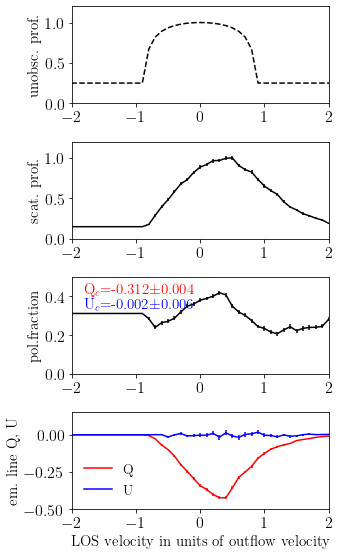

In [8]:
Rp=3.0 # peak line to continuum ratio for the unobscured spectrum
fc=(theta2-theta1)/(Rp*vin*2*math.pi*(math.cos(theta1)-math.cos(theta2))) # this is the continuum
# level in the spectral space for the peak line to continuum ratio above

# plot the resulting profiles
fig = plt.figure(num=1,figsize=(5,8))
fig.patch.set_facecolor('white')
fig.subplots_adjust(left=0.2, bottom=0.15, right=0.9, top=0.95, wspace=.2, hspace=.2)
plt.clf()
ax=plt.subplot(411)
func=fc*Delta_Omega+funobs
ax.plot(vlos,func/np.max(func),color='black',ls='dashed')
ax.set_ylim(bottom=0.,top=1.2)
ax.set_xlim(left=-2.,right=2.0)
ax.set_ylabel('unobsc. prof.', fontsize=15, color='black')

ax=plt.subplot(412)
func=fvlos+fc*cont
ax.errorbar(vlos,func/np.max(func),(efvlos+fc*econt)/np.max(func),color='black')
ax.set_ylim(bottom=0.,top=1.2)
ax.set_xlim(left=-2.,right=2.0)
ax.set_ylabel('scat. prof.', fontsize=15, color='black')

ax=plt.subplot(413)
ax.errorbar(vlos,abs(fvlosq+fc*contq)/func,(efvlosq+fc*econtq)/func,color='black')
ax.set_ylim(bottom=0., top=0.5)
ax.set_xlim(left=-2.,right=2.0)
ax.set_ylabel('pol.fraction', fontsize=15, color='black')
ax.text(0.05,0.8,'Q$_c$=%.3f$\pm$%.3f' % (contq/cont, econtq/cont),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='red', fontsize=15)
ax.text(0.05,0.65,'U$_c$=%.3f$\pm$%.3f' % (contu/cont, econtu/cont),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='blue', fontsize=15)

ax=plt.subplot(414)
ax.errorbar(vlos,fvlosq/np.max(fvlos),efvlosq/np.max(fvlos),color='red', label="Q")
ax.errorbar(vlos,fvlosu/np.max(fvlos),efvlosu/np.max(fvlos),color='blue', label="U")
ax.set_ylim(bottom=-0.5, top=0.15)
ax.set_xlim(left=-2.,right=2.0)
# get handles
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
# use them in the legend
ax.legend(handles, labels, loc='lower left', frameon=False)

ax.set_ylabel('em. line Q, U', fontsize=15, color='black')
ax.set_xlabel('LOS velocity in units of outflow velocity', fontsize=15, color='black')
fig.tight_layout()

plt.savefig(outfile)
plt.show()




In [9]:
# to save the data from calculations, especially the long calculation with sig=0.01 and nmc_large=1e5:
# THE METADATA JUST REFUSES TO BE SAVED, so doesn't work. we'll do it manually
#t = Table([vlos, fvlos, efvlos, fvlosq, efvlosq, fvlosu, efvlosu], 
#    names=('vlos', 'fvlos', 'efvlos', 'fvlosq', 'efvlosq', 'fvlosu', 'efvlosu'), 
#    meta={'keywords':{'fc': fc,'cont':cont,'econt':econt,'contq':contq,'econtq':econtq,'contu':contu,'econtu':econtu}})
#ascii.write(t,datfile,format='ipac',overwrite=True)

In [10]:
# to save the data from calculations:
def mywrite_output(datfile):
    myfile=open(datfile,'w')
    today = date.today().strftime("%d-%m-%Y")
    myfile.write('\ Created by https://github.com/zakamska/polarized_outflows on '+today+'\n')
    myfile.write('\ Please check the link above for an appropriate citation!\n')
    myfile.write('\\fc = '+("%.5f" % fc)+'\n')
    myfile.write('\cont = '+("%.5f" % cont)+'\n')
    myfile.write('\econt = '+("%.5f" % econt)+'\n')
    myfile.write('\contq = '+("%.5f" % contq)+'\n')
    myfile.write('\econtq = '+("%.5f" % econtq)+'\n')
    myfile.write('\contu = '+("%.5f" % contu)+'\n')
    myfile.write('\econtu = '+("%.5f" % econtu)+'\n')
    myfile.write('|          vlos|         fvlos|        efvlos|        fvlosq|       efvlosq|        fvlosu|       efvlosu|\n')
    myfile.write('|        double|        double|        double|        double|        double|        double|        double|\n')
    myfile.write('|              |              |              |              |              |              |              |\n')
    myfile.write('|          null|          null|          null|          null|          null|          null|          null|\n')
    for i,u in enumerate(vlos):
        a1=("%.5f" % vlos[i]).rjust(15)+' '
        a2=("%.5e" % fvlos[i]).rjust(14)+' '
        a3=("%.5e" % efvlos[i]).rjust(14)+' '
        a4=("%.5e" % fvlosq[i]).rjust(14)+' '
        a5=("%.5e" % efvlosq[i]).rjust(14)+' '
        a6=("%.5e" % fvlosu[i]).rjust(14)+' '
        a7=("%.5e" % efvlosu[i]).rjust(14)+' '
        myfile.write(a1+a2+a3+a4+a5+a6+a7+'\n')
    myfile.close()
    return()
mywrite_output(datfile)

()

In [11]:
# let's actually double-check that this file can be usefully read: 
mydata = ascii.read(datfile)
print(mydata.meta['keywords']['fc']['value'])
print(mydata['vlos'][5], mydata['fvlos'][5])

0.11111
-2.0 0.0


<h3> Now polar outflow but let's incline the cone toward the observer </h3>

In [12]:
# the geometry of the emitter, scatterer and observer and resulting file names
theta1=0.*math.pi/180. # movement of the emitter
theta2=60.*math.pi/180.
theta_s1=0.*math.pi/180. # movement of the scatterer
theta_s2=60.*math.pi/180.
theta_obs=45.*math.pi/180. # observer's angle
vin=1.0 # emitting outflow velocity
vscat=1.0 # scattering outflow velocity
fname=begin_fname+'00_60_00_60_45'

datfile=fname+'.tbl'
outfile=fname+'.pdf'

In [13]:
# these are the actual calculations
# set up the arrays of results
vlos=np.arange(-2.5,2.5,0.1)
fvlos,efvlos,fvlosq,efvlosq,fvlosu,efvlosu = [np.zeros(np.size(vlos)) for _ in range(6)]

domainsize = (theta2-theta1)*(theta_s2-theta_s1)*(2*math.pi)**2.
ind=np.arange(np.size(vlos))
random.seed(1)
for i in ind:
    newint=lambda x: integrand_i([x[0],x[1],x[2],x[3],vlos[i]])
    fvlos[i], efvlos[i] = mcint.integrate(newint, sampler(), measure=domainsize, n=nmc_large)
    newint_q=lambda x: integrand_q([x[0],x[1],x[2],x[3],vlos[i]])
    fvlosq[i], efvlosq[i] = mcint.integrate(newint_q, sampler(), measure=domainsize, n=nmc_large)
    newint_u=lambda x: integrand_u([x[0],x[1],x[2],x[3],vlos[i]])
    fvlosu[i], efvlosu[i] = mcint.integrate(newint_u, sampler(), measure=domainsize, n=nmc_large)
    
# set up the arrays for the unobscured emission line profile
funobs,efunobs = [np.zeros(np.size(vlos)) for _ in range(2)]

## this is the numerical calculation of the unobscured profile if we need it
domain_unobs = (theta2-theta1)*(2*math.pi)
ind=np.arange(np.size(vlos))
for i in ind:
    random.seed(1)
    newint=lambda x: integrand_unobs([x[0],x[1],vlos[i]])
    funobs[i], efunobs[i] = mcint.integrate(newint, sampler_unobs(), measure=domain_unobs, n=nmc_small)

# now let's calculate continuum polarization
domain_cont=(theta_s2-theta_s1)*(2*math.pi)
# so we integrate over the integration range. But the continuum emission is only escaping 
# along a fraction of solid angle
Delta_Omega=2*math.pi*(math.cos(theta1)-math.cos(theta2))
cont, econt=mcint.integrate(int_cont_i, sampler_cont(), measure=domain_cont, n=nmc_small)
contq, econtq=mcint.integrate(int_cont_q, sampler_cont(), measure=domain_cont, n=nmc_small)
contu, econtu=mcint.integrate(int_cont_u, sampler_cont(), measure=domain_cont, n=nmc_small)
# I am still not 100% sure why we are normalizing things this way, but let's give it a shot... 
# and I am in disbelief that there isn't a more elegant way to do this: 
cont=cont*Delta_Omega
econt=econt*Delta_Omega
contq=contq*Delta_Omega
econtq=econtq*Delta_Omega
contu=contu*Delta_Omega
econtu=econtu*Delta_Omega


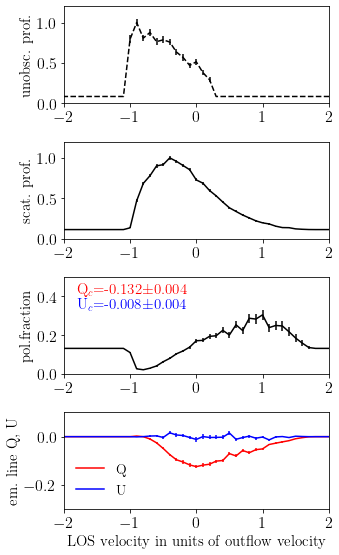

()

In [14]:
Rp=3.0 # peak line to continuum ratio for the unobscured spectrum
fc=(theta2-theta1)/(Rp*vin*2*math.pi*(math.cos(theta1)-math.cos(theta2))) # this is the continuum
# level in the spectral space for the peak line to continuum ratio above

# plot the resulting profiles
fig = plt.figure(num=1,figsize=(5,8))
fig.patch.set_facecolor('white')
fig.subplots_adjust(left=0.2, bottom=0.15, right=0.9, top=0.95, wspace=.2, hspace=.2)
plt.clf()
ax=plt.subplot(411)
func=fc*Delta_Omega+funobs
ax.errorbar(vlos,func/np.max(func),efunobs/np.max(func),color='black', ls='dashed')
ax.set_ylim(bottom=0.,top=1.2)
ax.set_xlim(left=-2.,right=2.0)
ax.set_ylabel('unobsc. prof.', fontsize=15, color='black')

ax=plt.subplot(412)
func=fvlos+fc*cont
ax.errorbar(vlos,func/np.max(func),(efvlos+fc*econt)/np.max(func),color='black')
ax.set_ylim(bottom=0.,top=1.2)
ax.set_xlim(left=-2.,right=2.0)
ax.set_ylabel('scat. prof.', fontsize=15, color='black')

ax=plt.subplot(413)
ax.errorbar(vlos,abs(fvlosq+fc*contq)/func,(efvlosq+fc*econtq)/func,color='black')
ax.set_ylim(bottom=0., top=0.5)
ax.set_xlim(left=-2.,right=2.0)
ax.set_ylabel('pol.fraction', fontsize=15, color='black')
ax.text(0.05,0.8,'Q$_c$=%.3f$\pm$%.3f' % (contq/cont, econtq/cont),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='red', fontsize=15)
ax.text(0.05,0.65,'U$_c$=%.3f$\pm$%.3f' % (contu/cont, econtu/cont),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='blue', fontsize=15)

ax=plt.subplot(414)
ax.errorbar(vlos,fvlosq/np.max(fvlos),efvlosq/np.max(fvlos),color='red', label="Q")
ax.errorbar(vlos,fvlosu/np.max(fvlos),efvlosu/np.max(fvlos),color='blue', label="U")
ax.set_ylim(bottom=-0.3, top=0.1)
ax.set_xlim(left=-2.,right=2.0)
# get handles
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
# use them in the legend
ax.legend(handles, labels, loc='lower left', frameon=False)

ax.set_ylabel('em. line Q, U', fontsize=15, color='black')
ax.set_xlabel('LOS velocity in units of outflow velocity', fontsize=15, color='black')
fig.tight_layout()

plt.savefig(outfile)
plt.show()

mywrite_output(datfile)

<h3> Now equatorial outflow, edge-on </h3>

In [15]:
# the geometry of the emitter, scatterer and observer and resulting file names
theta1=0.*math.pi/180. # movement of the emitter
theta2=30.*math.pi/180.
theta_s1=30.*math.pi/180. # movement of the scatterer
theta_s2=90.*math.pi/180.
theta_obs=90.*math.pi/180. # observer's angle
fname=begin_fname+'00_30_30_90_90'

datfile=fname+'.tbl'
outfile=fname+'.pdf'

In [16]:
# these are the actual calculations
# set up the arrays of results
vlos=np.arange(-2.5,2.5,0.1)
fvlos,efvlos,fvlosq,efvlosq,fvlosu,efvlosu = [np.zeros(np.size(vlos)) for _ in range(6)]

domainsize = (theta2-theta1)*(theta_s2-theta_s1)*(2*math.pi)**2.
ind=np.arange(np.size(vlos))
random.seed(1)
for i in ind:
    newint=lambda x: integrand_i([x[0],x[1],x[2],x[3],vlos[i]])
    fvlos[i], efvlos[i] = mcint.integrate(newint, sampler(), measure=domainsize, n=nmc_large)
    newint_q=lambda x: integrand_q([x[0],x[1],x[2],x[3],vlos[i]])
    fvlosq[i], efvlosq[i] = mcint.integrate(newint_q, sampler(), measure=domainsize, n=nmc_large)
    newint_u=lambda x: integrand_u([x[0],x[1],x[2],x[3],vlos[i]])
    fvlosu[i], efvlosu[i] = mcint.integrate(newint_u, sampler(), measure=domainsize, n=nmc_large)
    
# set up the arrays for the unobscured emission line profile
funobs,efunobs = [np.zeros(np.size(vlos)) for _ in range(2)]

## this is the numerical calculation of the unobscured profile if we need it
domain_unobs = (theta2-theta1)*(2*math.pi)
ind=np.arange(np.size(vlos))
for i in ind:
    random.seed(1)
    newint=lambda x: integrand_unobs([x[0],x[1],vlos[i]])
    funobs[i], efunobs[i] = mcint.integrate(newint, sampler_unobs(), measure=domain_unobs, n=nmc_small)

# now let's calculate continuum polarization
domain_cont=(theta_s2-theta_s1)*(2*math.pi)
# so we integrate over the integration range. But the continuum emission is only escaping 
# along a fraction of solid angle
Delta_Omega=2*math.pi*(math.cos(theta1)-math.cos(theta2))
cont, econt=mcint.integrate(int_cont_i, sampler_cont(), measure=domain_cont, n=nmc_small)
contq, econtq=mcint.integrate(int_cont_q, sampler_cont(), measure=domain_cont, n=nmc_small)
contu, econtu=mcint.integrate(int_cont_u, sampler_cont(), measure=domain_cont, n=nmc_small)
# I am still not 100% sure why we are normalizing things this way, but let's give it a shot... 
# and I am in disbelief that there isn't a more elegant way to do this: 
cont=cont*Delta_Omega
econt=econt*Delta_Omega
contq=contq*Delta_Omega
econtq=econtq*Delta_Omega
contu=contu*Delta_Omega
econtu=econtu*Delta_Omega


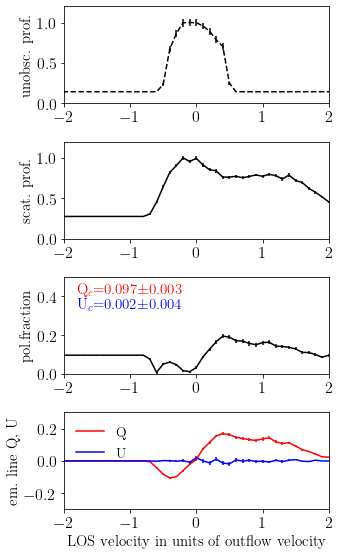

()

In [17]:
Rp=3.0 # peak line to continuum ratio for the unobscured spectrum
fc=(theta2-theta1)/(Rp*vin*2*math.pi*(math.cos(theta1)-math.cos(theta2))) # this is the continuum
# level in the spectral space for the peak line to continuum ratio above

# plot the resulting profiles
fig = plt.figure(num=1,figsize=(5,8))
fig.patch.set_facecolor('white')
fig.subplots_adjust(left=0.2, bottom=0.15, right=0.9, top=0.95, wspace=.2, hspace=.2)
plt.clf()
ax=plt.subplot(411)
func=fc*Delta_Omega+funobs
ax.errorbar(vlos,func/np.max(func),efunobs/np.max(func),color='black', ls='dashed')
ax.set_ylim(bottom=0.,top=1.2)
ax.set_xlim(left=-2.,right=2.0)
ax.set_ylabel('unobsc. prof.', fontsize=15, color='black')

ax=plt.subplot(412)
func=fvlos+fc*cont
ax.errorbar(vlos,func/np.max(func),(efvlos+fc*econt)/np.max(func),color='black')
ax.set_ylim(bottom=0.,top=1.2)
ax.set_xlim(left=-2.,right=2.0)
ax.set_ylabel('scat. prof.', fontsize=15, color='black')

ax=plt.subplot(413)
ax.errorbar(vlos,abs(fvlosq+fc*contq)/func,(efvlosq+fc*econtq)/func,color='black')
ax.set_ylim(bottom=0., top=0.5)
ax.set_xlim(left=-2.,right=2.0)
ax.set_ylabel('pol.fraction', fontsize=15, color='black')
ax.text(0.05,0.8,'Q$_c$=%.3f$\pm$%.3f' % (contq/cont, econtq/cont),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='red', fontsize=15)
ax.text(0.05,0.65,'U$_c$=%.3f$\pm$%.3f' % (contu/cont, econtu/cont),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='blue', fontsize=15)

ax=plt.subplot(414)
ax.errorbar(vlos,fvlosq/np.max(fvlos),efvlosq/np.max(fvlos),color='red', label="Q")
ax.errorbar(vlos,fvlosu/np.max(fvlos),efvlosu/np.max(fvlos),color='blue', label="U")
ax.set_ylim(bottom=-0.3, top=0.3)
ax.set_xlim(left=-2.,right=2.0)
# get handles
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
# use them in the legend
ax.legend(handles, labels, loc='upper left', frameon=False)

ax.set_ylabel('em. line Q, U', fontsize=15, color='black')
ax.set_xlabel('LOS velocity in units of outflow velocity', fontsize=15, color='black')
fig.tight_layout()

plt.savefig(outfile)
plt.show()

mywrite_output(datfile)

<h3> Now equatorial outflow observed within its skin </h3>


In [18]:
# the geometry of the emitter, scatterer and observer and resulting file names
theta1=0.*math.pi/180. # movement of the emitter
theta2=30.*math.pi/180.
theta_s1=30.*math.pi/180. # movement of the scatterer
theta_s2=50.*math.pi/180.
theta_obs=40.*math.pi/180. # observer's angle
fname=begin_fname+'00_30_30_50_40'

datfile=fname+'.tbl'
outfile=fname+'.pdf'

In [19]:
# these are the actual calculations
# set up the arrays of results
vlos=np.arange(-2.5,2.5,0.1)
fvlos,efvlos,fvlosq,efvlosq,fvlosu,efvlosu = [np.zeros(np.size(vlos)) for _ in range(6)]

domainsize = (theta2-theta1)*(theta_s2-theta_s1)*(2*math.pi)**2.
ind=np.arange(np.size(vlos))
random.seed(1)
for i in ind:
    newint=lambda x: integrand_i([x[0],x[1],x[2],x[3],vlos[i]])
    fvlos[i], efvlos[i] = mcint.integrate(newint, sampler(), measure=domainsize, n=nmc_large)
    newint_q=lambda x: integrand_q([x[0],x[1],x[2],x[3],vlos[i]])
    fvlosq[i], efvlosq[i] = mcint.integrate(newint_q, sampler(), measure=domainsize, n=nmc_large)
    newint_u=lambda x: integrand_u([x[0],x[1],x[2],x[3],vlos[i]])
    fvlosu[i], efvlosu[i] = mcint.integrate(newint_u, sampler(), measure=domainsize, n=nmc_large)
    
# set up the arrays for the unobscured emission line profile
funobs,efunobs = [np.zeros(np.size(vlos)) for _ in range(2)]

## this is the numerical calculation of the unobscured profile if we need it
domain_unobs = (theta2-theta1)*(2*math.pi)
ind=np.arange(np.size(vlos))
for i in ind:
    random.seed(1)
    newint=lambda x: integrand_unobs([x[0],x[1],vlos[i]])
    funobs[i], efunobs[i] = mcint.integrate(newint, sampler_unobs(), measure=domain_unobs, n=nmc_small)

# now let's calculate continuum polarization
domain_cont=(theta_s2-theta_s1)*(2*math.pi)
# so we integrate over the integration range. But the continuum emission is only escaping 
# along a fraction of solid angle
Delta_Omega=2*math.pi*(math.cos(theta1)-math.cos(theta2))
cont, econt=mcint.integrate(int_cont_i, sampler_cont(), measure=domain_cont, n=nmc_small)
contq, econtq=mcint.integrate(int_cont_q, sampler_cont(), measure=domain_cont, n=nmc_small)
contu, econtu=mcint.integrate(int_cont_u, sampler_cont(), measure=domain_cont, n=nmc_small)
# I am still not 100% sure why we are normalizing things this way, but let's give it a shot... 
# and I am in disbelief that there isn't a more elegant way to do this: 
cont=cont*Delta_Omega
econt=econt*Delta_Omega
contq=contq*Delta_Omega
econtq=econtq*Delta_Omega
contu=contu*Delta_Omega
econtu=econtu*Delta_Omega


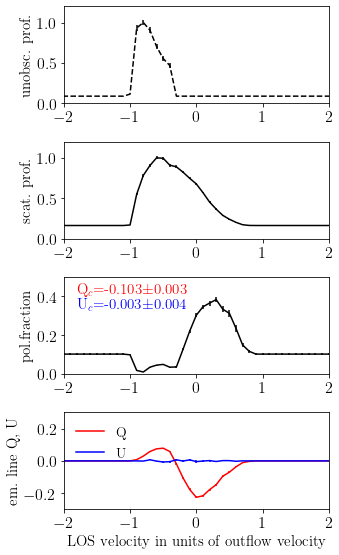

()

In [20]:
Rp=3.0 # peak line to continuum ratio for the unobscured spectrum
fc=(theta2-theta1)/(Rp*vin*2*math.pi*(math.cos(theta1)-math.cos(theta2))) # this is the continuum
# level in the spectral space for the peak line to continuum ratio above

# plot the resulting profiles
fig = plt.figure(num=1,figsize=(5,8))
fig.patch.set_facecolor('white')
fig.subplots_adjust(left=0.2, bottom=0.15, right=0.9, top=0.95, wspace=.2, hspace=.2)
plt.clf()
ax1=plt.subplot(411)
func=fc*Delta_Omega+funobs
ax1.errorbar(vlos,func/np.max(func),efunobs/np.max(func),color='black', ls='dashed')
ax1.set_ylim(bottom=0.,top=1.2)
ax1.set_xlim(left=-2.,right=2.0)
ax1.set_ylabel('unobsc. prof.', fontsize=15, color='black')

ax2=plt.subplot(412, sharex=ax1)
func=fvlos+fc*cont
ax2.errorbar(vlos,func/np.max(func),(efvlos+fc*econt)/np.max(func),color='black')
ax2.set_ylim(bottom=0.,top=1.2)
ax2.set_xlim(left=-2.,right=2.0)
ax2.set_ylabel('scat. prof.', fontsize=15, color='black')

ax3=plt.subplot(413, sharex=ax1)
ax3.errorbar(vlos,abs(fvlosq+fc*contq)/func,(efvlosq+fc*econtq)/func,color='black')
ax3.set_ylim(bottom=0., top=0.5)
ax3.set_xlim(left=-2.,right=2.0)
ax3.set_ylabel('pol.fraction', fontsize=15, color='black')
ax3.text(0.05,0.8,'Q$_c$=%.3f$\pm$%.3f' % (contq/cont, econtq/cont),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax3.transAxes,
        color='red', fontsize=15)
ax3.text(0.05,0.65,'U$_c$=%.3f$\pm$%.3f' % (contu/cont, econtu/cont),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax3.transAxes,
        color='blue', fontsize=15)

ax4=plt.subplot(414, sharex=ax1)
ax4.errorbar(vlos,fvlosq/np.max(fvlos),efvlosq/np.max(fvlos),color='red', label="Q")
ax4.errorbar(vlos,fvlosu/np.max(fvlos),efvlosu/np.max(fvlos),color='blue', label="U")
ax4.set_ylim(bottom=-0.3, top=0.3)
ax4.set_xlim(left=-2.,right=2.0)
# get handles
handles, labels = ax4.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
# use them in the legend
ax4.legend(handles, labels, loc='upper left', frameon=False)
ax4.set_ylabel('em. line Q, U', fontsize=15, color='black')
ax4.set_xlabel('LOS velocity in units of outflow velocity', fontsize=15, color='black')
fig.tight_layout()

plt.savefig(outfile)
plt.show()

mywrite_output(datfile)

<h3> Now equatorial outflow observed within its skin -- same as above but slightly different parameters </h3>


In [21]:
# the geometry of the emitter, scatterer and observer and resulting file names
theta1=0.*math.pi/180. # movement of the emitter
theta2=50.*math.pi/180.
theta_s1=50.*math.pi/180. # movement of the scatterer
theta_s2=70.*math.pi/180.
theta_obs=60.*math.pi/180. # observer's angle
fname=begin_fname+'00_50_50_70_60'

datfile=fname+'.tbl'
outfile=fname+'.pdf'

In [22]:
# these are the actual calculations
# set up the arrays of results
vlos=np.arange(-2.5,2.5,0.1)
fvlos,efvlos,fvlosq,efvlosq,fvlosu,efvlosu = [np.zeros(np.size(vlos)) for _ in range(6)]

domainsize = (theta2-theta1)*(theta_s2-theta_s1)*(2*math.pi)**2.
ind=np.arange(np.size(vlos))
random.seed(1)
for i in ind:
    newint=lambda x: integrand_i([x[0],x[1],x[2],x[3],vlos[i]])
    fvlos[i], efvlos[i] = mcint.integrate(newint, sampler(), measure=domainsize, n=nmc_large)
    newint_q=lambda x: integrand_q([x[0],x[1],x[2],x[3],vlos[i]])
    fvlosq[i], efvlosq[i] = mcint.integrate(newint_q, sampler(), measure=domainsize, n=nmc_large)
    newint_u=lambda x: integrand_u([x[0],x[1],x[2],x[3],vlos[i]])
    fvlosu[i], efvlosu[i] = mcint.integrate(newint_u, sampler(), measure=domainsize, n=nmc_large)
    
# set up the arrays for the unobscured emission line profile
funobs,efunobs = [np.zeros(np.size(vlos)) for _ in range(2)]

## this is the numerical calculation of the unobscured profile if we need it
domain_unobs = (theta2-theta1)*(2*math.pi)
ind=np.arange(np.size(vlos))
for i in ind:
    random.seed(1)
    newint=lambda x: integrand_unobs([x[0],x[1],vlos[i]])
    funobs[i], efunobs[i] = mcint.integrate(newint, sampler_unobs(), measure=domain_unobs, n=nmc_small)

# now let's calculate continuum polarization
domain_cont=(theta_s2-theta_s1)*(2*math.pi)
# so we integrate over the integration range. But the continuum emission is only escaping 
# along a fraction of solid angle
Delta_Omega=2*math.pi*(math.cos(theta1)-math.cos(theta2))
cont, econt=mcint.integrate(int_cont_i, sampler_cont(), measure=domain_cont, n=nmc_small)
contq, econtq=mcint.integrate(int_cont_q, sampler_cont(), measure=domain_cont, n=nmc_small)
contu, econtu=mcint.integrate(int_cont_u, sampler_cont(), measure=domain_cont, n=nmc_small)
# I am still not 100% sure why we are normalizing things this way, but let's give it a shot... 
# and I am in disbelief that there isn't a more elegant way to do this: 
cont=cont*Delta_Omega
econt=econt*Delta_Omega
contq=contq*Delta_Omega
econtq=econtq*Delta_Omega
contu=contu*Delta_Omega
econtu=econtu*Delta_Omega


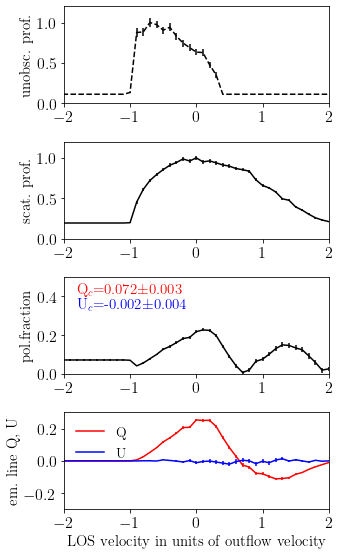

()

In [23]:
Rp=3.0 # peak line to continuum ratio for the unobscured spectrum
fc=(theta2-theta1)/(Rp*vin*2*math.pi*(math.cos(theta1)-math.cos(theta2))) # this is the continuum
# level in the spectral space for the peak line to continuum ratio above

# plot the resulting profiles
fig = plt.figure(num=1,figsize=(5,8))
fig.patch.set_facecolor('white')
fig.subplots_adjust(left=0.2, bottom=0.15, right=0.9, top=0.95, wspace=.2, hspace=.2)
plt.clf()
ax1=plt.subplot(411)
func=fc*Delta_Omega+funobs
ax1.errorbar(vlos,func/np.max(func),efunobs/np.max(func),color='black', ls='dashed')
ax1.set_ylim(bottom=0.,top=1.2)
ax1.set_xlim(left=-2.,right=2.0)
ax1.set_ylabel('unobsc. prof.', fontsize=15, color='black')

ax2=plt.subplot(412, sharex=ax1)
func=fvlos+fc*cont
ax2.errorbar(vlos,func/np.max(func),(efvlos+fc*econt)/np.max(func),color='black')
ax2.set_ylim(bottom=0.,top=1.2)
ax2.set_xlim(left=-2.,right=2.0)
ax2.set_ylabel('scat. prof.', fontsize=15, color='black')

ax3=plt.subplot(413, sharex=ax1)
ax3.errorbar(vlos,abs(fvlosq+fc*contq)/func,(efvlosq+fc*econtq)/func,color='black')
ax3.set_ylim(bottom=0., top=0.5)
ax3.set_xlim(left=-2.,right=2.0)
ax3.set_ylabel('pol.fraction', fontsize=15, color='black')
ax3.text(0.05,0.8,'Q$_c$=%.3f$\pm$%.3f' % (contq/cont, econtq/cont),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax3.transAxes,
        color='red', fontsize=15)
ax3.text(0.05,0.65,'U$_c$=%.3f$\pm$%.3f' % (contu/cont, econtu/cont),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax3.transAxes,
        color='blue', fontsize=15)

ax4=plt.subplot(414, sharex=ax1)
ax4.errorbar(vlos,fvlosq/np.max(fvlos),efvlosq/np.max(fvlos),color='red', label="Q")
ax4.errorbar(vlos,fvlosu/np.max(fvlos),efvlosu/np.max(fvlos),color='blue', label="U")
ax4.set_ylim(bottom=-0.3, top=0.3)
ax4.set_xlim(left=-2.,right=2.0)
# get handles
handles, labels = ax4.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
# use them in the legend
ax4.legend(handles, labels, loc='upper left', frameon=False)
ax4.set_ylabel('em. line Q, U', fontsize=15, color='black')
ax4.set_xlabel('LOS velocity in units of outflow velocity', fontsize=15, color='black')
fig.tight_layout()

plt.savefig(outfile)
plt.show()

mywrite_output(datfile)

<h3>Now same equatorial outflow as the one that actually worked, but now the original emission line is also produced there</h3>

In [24]:
# the geometry of the emitter, scatterer and observer and resulting file names
theta1=30.*math.pi/180. # movement of the emitter
theta2=50.*math.pi/180.
theta_s1=30.*math.pi/180. # movement of the scatterer
theta_s2=50.*math.pi/180.
theta_obs=40.*math.pi/180. # observer's angle
fname=begin_fname+'30_50_30_50_40'

datfile=fname+'.tbl'
outfile=fname+'.pdf'

In [25]:
# these are the actual calculations
# set up the arrays of results
vlos=np.arange(-2.5,2.5,0.1)
fvlos,efvlos,fvlosq,efvlosq,fvlosu,efvlosu = [np.zeros(np.size(vlos)) for _ in range(6)]

domainsize = (theta2-theta1)*(theta_s2-theta_s1)*(2*math.pi)**2.
ind=np.arange(np.size(vlos))
random.seed(1)
for i in ind:
    newint=lambda x: integrand_i([x[0],x[1],x[2],x[3],vlos[i]])
    fvlos[i], efvlos[i] = mcint.integrate(newint, sampler(), measure=domainsize, n=nmc_large)
    newint_q=lambda x: integrand_q([x[0],x[1],x[2],x[3],vlos[i]])
    fvlosq[i], efvlosq[i] = mcint.integrate(newint_q, sampler(), measure=domainsize, n=nmc_large)
    newint_u=lambda x: integrand_u([x[0],x[1],x[2],x[3],vlos[i]])
    fvlosu[i], efvlosu[i] = mcint.integrate(newint_u, sampler(), measure=domainsize, n=nmc_large)
    
# set up the arrays for the unobscured emission line profile
funobs,efunobs = [np.zeros(np.size(vlos)) for _ in range(2)]

## this is the numerical calculation of the unobscured profile if we need it
domain_unobs = (theta2-theta1)*(2*math.pi)
ind=np.arange(np.size(vlos))
for i in ind:
    random.seed(1)
    newint=lambda x: integrand_unobs([x[0],x[1],vlos[i]])
    funobs[i], efunobs[i] = mcint.integrate(newint, sampler_unobs(), measure=domain_unobs, n=nmc_small)

# now let's calculate continuum polarization
domain_cont=(theta_s2-theta_s1)*(2*math.pi)
# so we integrate over the integration range. But the continuum emission is only escaping 
# along a fraction of solid angle
Delta_Omega=2*math.pi*(math.cos(theta1)-math.cos(theta2))
cont, econt=mcint.integrate(int_cont_i, sampler_cont(), measure=domain_cont, n=nmc_small)
contq, econtq=mcint.integrate(int_cont_q, sampler_cont(), measure=domain_cont, n=nmc_small)
contu, econtu=mcint.integrate(int_cont_u, sampler_cont(), measure=domain_cont, n=nmc_small)
# I am still not 100% sure why we are normalizing things this way, but let's give it a shot... 
# and I am in disbelief that there isn't a more elegant way to do this: 
cont=cont*Delta_Omega
econt=econt*Delta_Omega
contq=contq*Delta_Omega
econtq=econtq*Delta_Omega
contu=contu*Delta_Omega
econtu=econtu*Delta_Omega


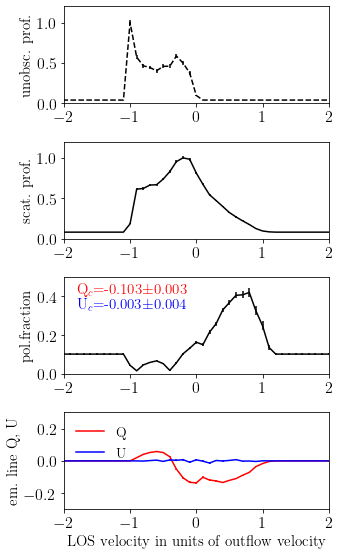

()

In [26]:
Rp=3.0 # peak line to continuum ratio for the unobscured spectrum
fc=(theta2-theta1)/(Rp*vin*2*math.pi*(math.cos(theta1)-math.cos(theta2))) # this is the continuum
# level in the spectral space for the peak line to continuum ratio above

# plot the resulting profiles
fig = plt.figure(num=1,figsize=(5,8))
fig.patch.set_facecolor('white')
fig.subplots_adjust(left=0.2, bottom=0.15, right=0.9, top=0.95, wspace=.2, hspace=.2)
plt.clf()
ax1=plt.subplot(411)
func=fc*Delta_Omega+funobs
ax1.errorbar(vlos,func/np.max(func),efunobs/np.max(func),color='black', ls='dashed')
ax1.set_ylim(bottom=0.,top=1.2)
ax1.set_xlim(left=-2.,right=2.0)
ax1.set_ylabel('unobsc. prof.', fontsize=15, color='black')

ax2=plt.subplot(412)
func=fvlos+fc*cont
ax2.errorbar(vlos,func/np.max(func),(efvlos+fc*econt)/np.max(func),color='black')
ax2.set_ylim(bottom=0.,top=1.2)
ax2.set_xlim(left=-2.,right=2.0)
ax2.set_ylabel('scat. prof.', fontsize=15, color='black')

ax3=plt.subplot(413)
ax3.errorbar(vlos,abs(fvlosq+fc*contq)/func,(efvlosq+fc*econtq)/func,color='black')
ax3.set_ylim(bottom=0., top=0.5)
ax3.set_xlim(left=-2.,right=2.0)
ax3.set_ylabel('pol.fraction', fontsize=15, color='black')
ax3.text(0.05,0.8,'Q$_c$=%.3f$\pm$%.3f' % (contq/cont, econtq/cont),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax3.transAxes,
        color='red', fontsize=15)
ax3.text(0.05,0.65,'U$_c$=%.3f$\pm$%.3f' % (contu/cont, econtu/cont),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax3.transAxes,
        color='blue', fontsize=15)

ax4=plt.subplot(414)
ax4.errorbar(vlos,fvlosq/np.max(fvlos),efvlosq/np.max(fvlos),color='red', label="Q")
ax4.errorbar(vlos,fvlosu/np.max(fvlos),efvlosu/np.max(fvlos),color='blue', label="U")
ax4.set_ylim(bottom=-0.3, top=0.3)
ax4.set_xlim(left=-2.,right=2.0)
# get handles
handles, labels = ax4.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
# use them in the legend
ax4.legend(handles, labels, loc='upper left', frameon=False)
ax4.set_ylabel('em. line Q, U', fontsize=15, color='black')
ax4.set_xlabel('LOS velocity in units of outflow velocity', fontsize=15, color='black')
fig.tight_layout()

plt.savefig(outfile)
plt.show()

mywrite_output(datfile)

<h3>One more equatorial model, very small opening angle</h3>

In [27]:
# the geometry of the emitter, scatterer and observer and resulting file names
theta1=0.*math.pi/180. # movement of the emitter
theta2=30.*math.pi/180.
theta_s1=20.*math.pi/180. # movement of the scatterer
theta_s2=30.*math.pi/180.
theta_obs=25.*math.pi/180. # observer's angle
fname=begin_fname+'00_30_20_30_25'

datfile=fname+'.tbl'
outfile=fname+'.pdf'

In [28]:
# these are the actual calculations
# set up the arrays of results
vlos=np.arange(-2.5,1.,0.05)
fvlos,efvlos,fvlosq,efvlosq,fvlosu,efvlosu = [np.zeros(np.size(vlos)) for _ in range(6)]

domainsize = (theta2-theta1)*(theta_s2-theta_s1)*(2*math.pi)**2.
ind=np.arange(np.size(vlos))
random.seed(1)
for i in ind:
    newint=lambda x: integrand_i([x[0],x[1],x[2],x[3],vlos[i]])
    fvlos[i], efvlos[i] = mcint.integrate(newint, sampler(), measure=domainsize, n=nmc_large)
    newint_q=lambda x: integrand_q([x[0],x[1],x[2],x[3],vlos[i]])
    fvlosq[i], efvlosq[i] = mcint.integrate(newint_q, sampler(), measure=domainsize, n=nmc_large)
    newint_u=lambda x: integrand_u([x[0],x[1],x[2],x[3],vlos[i]])
    fvlosu[i], efvlosu[i] = mcint.integrate(newint_u, sampler(), measure=domainsize, n=nmc_large)
    
# set up the arrays for the unobscured emission line profile
funobs,efunobs = [np.zeros(np.size(vlos)) for _ in range(2)]

## this is the numerical calculation of the unobscured profile if we need it
domain_unobs = (theta2-theta1)*(2*math.pi)
ind=np.arange(np.size(vlos))
for i in ind:
    random.seed(1)
    newint=lambda x: integrand_unobs([x[0],x[1],vlos[i]])
    funobs[i], efunobs[i] = mcint.integrate(newint, sampler_unobs(), measure=domain_unobs, n=nmc_small)

# now let's calculate continuum polarization
domain_cont=(theta_s2-theta_s1)*(2*math.pi)
# so we integrate over the integration range. But the continuum emission is only escaping 
# along a fraction of solid angle
Delta_Omega=2*math.pi*(math.cos(theta1)-math.cos(theta2))
cont, econt=mcint.integrate(int_cont_i, sampler_cont(), measure=domain_cont, n=nmc_small)
contq, econtq=mcint.integrate(int_cont_q, sampler_cont(), measure=domain_cont, n=nmc_small)
contu, econtu=mcint.integrate(int_cont_u, sampler_cont(), measure=domain_cont, n=nmc_small)
# I am still not 100% sure why we are normalizing things this way, but let's give it a shot... 
# and I am in disbelief that there isn't a more elegant way to do this: 
cont=cont*Delta_Omega
econt=econt*Delta_Omega
contq=contq*Delta_Omega
econtq=econtq*Delta_Omega
contu=contu*Delta_Omega
econtu=econtu*Delta_Omega


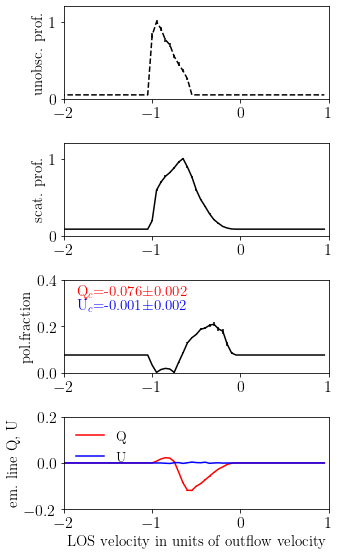

()

In [29]:
Rp=3.0 # peak line to continuum ratio for the unobscured spectrum
fc=(theta2-theta1)/(Rp*vin*2*math.pi*(math.cos(theta1)-math.cos(theta2))) # this is the continuum
# level in the spectral space for the peak line to continuum ratio above

# plot the resulting profiles
fig = plt.figure(num=1,figsize=(5,8))
fig.patch.set_facecolor('white')
fig.subplots_adjust(left=0.2, bottom=0.15, right=0.9, top=0.95, wspace=.2, hspace=.2)
plt.clf()
ax1=plt.subplot(411)
func=fc*Delta_Omega+funobs
ax1.errorbar(vlos,func/np.max(func),efunobs/np.max(func),color='black', ls='dashed')
ax1.set_ylim(bottom=0.,top=1.2)
ax1.set_xlim(left=-2.,right=1.0)
ax1.set_ylabel('unobsc. prof.', fontsize=15, color='black')

ax2=plt.subplot(412)
func=fvlos+fc*cont
ax2.errorbar(vlos,func/np.max(func),(efvlos+fc*econt)/np.max(func),color='black')
ax2.set_ylim(bottom=0.,top=1.2)
ax2.set_xlim(left=-2.,right=1.0)
ax2.set_ylabel('scat. prof.', fontsize=15, color='black')

ax3=plt.subplot(413)
ax3.errorbar(vlos,abs(fvlosq+fc*contq)/func,(efvlosq+fc*econtq)/func,color='black')
ax3.set_ylim(bottom=0., top=0.4)
ax3.set_xlim(left=-2.,right=1.0)
ax3.set_ylabel('pol.fraction', fontsize=15, color='black')
ax3.text(0.05,0.8,'Q$_c$=%.3f$\pm$%.3f' % (contq/cont, econtq/cont),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax3.transAxes,
        color='red', fontsize=15)
ax3.text(0.05,0.65,'U$_c$=%.3f$\pm$%.3f' % (contu/cont, econtu/cont),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax3.transAxes,
        color='blue', fontsize=15)

ax4=plt.subplot(414)
ax4.errorbar(vlos,fvlosq/np.max(fvlos),efvlosq/np.max(fvlos),color='red', label="Q")
ax4.errorbar(vlos,fvlosu/np.max(fvlos),efvlosu/np.max(fvlos),color='blue', label="U")
ax4.set_ylim(bottom=-0.2, top=0.2)
ax4.set_xlim(left=-2.,right=1.0)
# get handles
handles, labels = ax4.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
# use them in the legend
ax4.legend(handles, labels, loc='upper left', frameon=False)
ax4.set_ylabel('em. line Q, U', fontsize=15, color='black')
ax4.set_xlabel('LOS velocity in units of outflow velocity', fontsize=15, color='black')
fig.tight_layout()

plt.savefig(outfile)
plt.show()

mywrite_output(datfile)

<h3>One final equatorial: the emission is produced both in the skin and in the funnel</h3>

In [30]:
# the geometry of the emitter, scatterer and observer and resulting file names
theta1=0.*math.pi/180. # movement of the emitter
theta2=50.*math.pi/180.
theta_s1=30.*math.pi/180. # movement of the scatterer
theta_s2=50.*math.pi/180.
theta_obs=40.*math.pi/180. # observer's angle
fname=begin_fname+'00_50_30_50_40'

datfile=fname+'.tbl'
outfile=fname+'.pdf'

In [31]:
# these are the actual calculations
# set up the arrays of results
vlos=np.arange(-2.5,2.5,0.1)
fvlos,efvlos,fvlosq,efvlosq,fvlosu,efvlosu = [np.zeros(np.size(vlos)) for _ in range(6)]

domainsize = (theta2-theta1)*(theta_s2-theta_s1)*(2*math.pi)**2.
ind=np.arange(np.size(vlos))
random.seed(1)
for i in ind:
    newint=lambda x: integrand_i([x[0],x[1],x[2],x[3],vlos[i]])
    fvlos[i], efvlos[i] = mcint.integrate(newint, sampler(), measure=domainsize, n=nmc_large)
    newint_q=lambda x: integrand_q([x[0],x[1],x[2],x[3],vlos[i]])
    fvlosq[i], efvlosq[i] = mcint.integrate(newint_q, sampler(), measure=domainsize, n=nmc_large)
    newint_u=lambda x: integrand_u([x[0],x[1],x[2],x[3],vlos[i]])
    fvlosu[i], efvlosu[i] = mcint.integrate(newint_u, sampler(), measure=domainsize, n=nmc_large)
    
# set up the arrays for the unobscured emission line profile
funobs,efunobs = [np.zeros(np.size(vlos)) for _ in range(2)]

## this is the numerical calculation of the unobscured profile if we need it
domain_unobs = (theta2-theta1)*(2*math.pi)
ind=np.arange(np.size(vlos))
for i in ind:
    random.seed(1)
    newint=lambda x: integrand_unobs([x[0],x[1],vlos[i]])
    funobs[i], efunobs[i] = mcint.integrate(newint, sampler_unobs(), measure=domain_unobs, n=nmc_small)

# now let's calculate continuum polarization
domain_cont=(theta_s2-theta_s1)*(2*math.pi)
# so we integrate over the integration range. But the continuum emission is only escaping 
# along a fraction of solid angle
Delta_Omega=2*math.pi*(math.cos(theta1)-math.cos(theta2))
cont, econt=mcint.integrate(int_cont_i, sampler_cont(), measure=domain_cont, n=nmc_small)
contq, econtq=mcint.integrate(int_cont_q, sampler_cont(), measure=domain_cont, n=nmc_small)
contu, econtu=mcint.integrate(int_cont_u, sampler_cont(), measure=domain_cont, n=nmc_small)
# I am still not 100% sure why we are normalizing things this way, but let's give it a shot... 
# and I am in disbelief that there isn't a more elegant way to do this: 
cont=cont*Delta_Omega
econt=econt*Delta_Omega
contq=contq*Delta_Omega
econtq=econtq*Delta_Omega
contu=contu*Delta_Omega
econtu=econtu*Delta_Omega


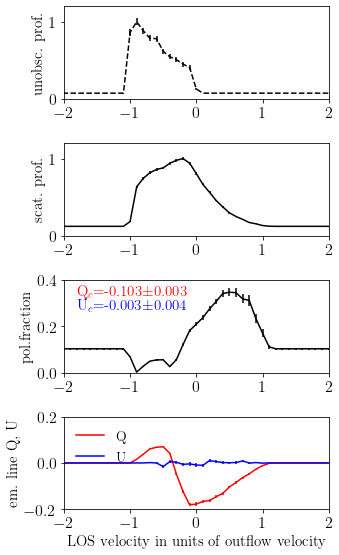

()

In [32]:
Rp=3.0 # peak line to continuum ratio for the unobscured spectrum
fc=(theta2-theta1)/(Rp*vin*2*math.pi*(math.cos(theta1)-math.cos(theta2))) # this is the continuum
# level in the spectral space for the peak line to continuum ratio above

# plot the resulting profiles
fig = plt.figure(num=1,figsize=(5,8))
fig.patch.set_facecolor('white')
fig.subplots_adjust(left=0.2, bottom=0.15, right=0.9, top=0.95, wspace=.2, hspace=.2)
plt.clf()
ax1=plt.subplot(411)
func=fc*Delta_Omega+funobs
ax1.errorbar(vlos,func/np.max(func),efunobs/np.max(func),color='black', ls='dashed')
ax1.set_ylim(bottom=0.,top=1.2)
ax1.set_xlim(left=-2.,right=2.0)
ax1.set_ylabel('unobsc. prof.', fontsize=15, color='black')

ax2=plt.subplot(412)
func=fvlos+fc*cont
ax2.errorbar(vlos,func/np.max(func),(efvlos+fc*econt)/np.max(func),color='black')
ax2.set_ylim(bottom=0.,top=1.2)
ax2.set_xlim(left=-2.,right=2.0)
ax2.set_ylabel('scat. prof.', fontsize=15, color='black')

ax3=plt.subplot(413)
ax3.errorbar(vlos,abs(fvlosq+fc*contq)/func,(efvlosq+fc*econtq)/func,color='black')
ax3.set_ylim(bottom=0., top=0.4)
ax3.set_xlim(left=-2.,right=2.0)
ax3.set_ylabel('pol.fraction', fontsize=15, color='black')
ax3.text(0.05,0.8,'Q$_c$=%.3f$\pm$%.3f' % (contq/cont, econtq/cont),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax3.transAxes,
        color='red', fontsize=15)
ax3.text(0.05,0.65,'U$_c$=%.3f$\pm$%.3f' % (contu/cont, econtu/cont),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax3.transAxes,
        color='blue', fontsize=15)

ax4=plt.subplot(414)
ax4.errorbar(vlos,fvlosq/np.max(fvlos),efvlosq/np.max(fvlos),color='red', label="Q")
ax4.errorbar(vlos,fvlosu/np.max(fvlos),efvlosu/np.max(fvlos),color='blue', label="U")
ax4.set_ylim(bottom=-0.2, top=0.2)
ax4.set_xlim(left=-2.,right=2.0)
# get handles
handles, labels = ax4.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
# use them in the legend
ax4.legend(handles, labels, loc='upper left', frameon=False)
ax4.set_ylabel('em. line Q, U', fontsize=15, color='black')
ax4.set_xlabel('LOS velocity in units of outflow velocity', fontsize=15, color='black')
fig.tight_layout()

plt.savefig(outfile)
plt.show()

mywrite_output(datfile)